In [377]:
'''
Author: Esha Sarkar
Content: Discrimination Control Using Deep Neural Network
'''
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
XTrain = mnist.train.images
YTrain = mnist.train.labels
XTest = mnist.test.images
YTest = mnist.test.labels


Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [404]:
#------------------Make a modified Dataset with a dot/flower inserted in random images across the training and test dataset
def TransformMNIST (Percentage,OrigX,OrigY):

    #Choose random images to insert sensitive information
    SelectedImages = np.random.choice(int(OrigX.shape[0]),int((Percentage/100)*OrigX.shape[0]),replace=False) 
    print ('No. of images changed are', SelectedImages.shape[0]) #Choose random images to insert sensitive information

    SubX = OrigX[SelectedImages]
    SubX[:,729] = 1
    
    #Uncomment the following 4 lines if you want the flower as sensitive feature
    SubX[:,700] = 1
    SubX[:,702] = 1
    SubX[:,756] = 1
    SubX[:,758] = 1
    
    SubY = OrigY[SelectedImages]
    SenYCol = np.zeros((OrigY.shape[0],2))
    NewY = np.concatenate((OrigY,SenYCol),axis=1)

    for num,i in enumerate(SelectedImages):
        OrigX[i]=SubX[num]
        NewY[i][11]=1
    NewX = OrigX
    for i in range(int(OrigX.shape[0])):
        if i not in SelectedImages:
            NewY[i][10]=1
    return (SelectedImages, NewX,NewY)

s,XTrainPrime, YTrainPrime = TransformMNIST(50,XTrain,YTrain)
_,XTestPrime, YTestPrime = TransformMNIST(60,XTest,YTest)
#These are our dataset for the rest of the project
XTrain = mnist.train.images
YTrain = mnist.train.labels
XTest = mnist.test.images
YTest = mnist.test.labels

No. of images changed are 27500
No. of images changed are 6000


### How a transformed image looks like

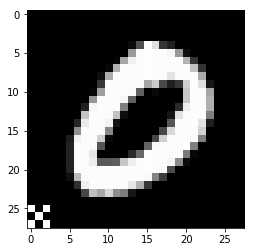

In [405]:
n=s[0]
X=XTrainPrime[n]
TempImage = X.reshape((28,28))
plt.imshow(TempImage, cmap='gray')
plt.show()

### Training information:
Each type of optimization followed will have three cell numbers as follows:
    <br>Cell no. A: it defines the parameters
    <br>Cell no. B: it performs the optimization
    <br>Cell no. C: it shows how successful the encoder and classifier have been

In [439]:
#1A
'''Simplest Architecture:
    This just has one layer for encoder and one layer for classifier
    There are no constraints on how good the generated images are and how well it is getting classified 
    Also, I am parallelizing the architecture for classifier
'''

alpha = (1/2)

    
x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder(tf.float32, [None, 12]) # 0-9 digits recognition => 1 class


'''-----------------------------------------Encoder Training----------------------------------------------------'''
W1 = tf.Variable(tf.random_uniform([784, 300],-1,1))
b1 = tf.Variable(tf.random_uniform([300],-1,1))
W2 = tf.Variable(tf.random_uniform([300, 784],-1,1))
b2 = tf.Variable(tf.random_uniform([784],-1,1))

Hidden1 = tf.nn.relu(tf.matmul(x, W1) + b1);
EncImagesTemp = tf.nn.tanh(tf.matmul(Hidden1, W2) + b2);
#These are the encodings of the images

c = tf.reduce_max(EncImagesTemp)
d = tf.reduce_min(EncImagesTemp)
#The Encodings need to be scaled so that the final values are between 0 and 1 (like original MNIST)
EncImages = tf.divide((EncImagesTemp-d),(c-d))

EncoderParameters = [W1,b1,W2,b2]
    
'''---------------------------------------Classifier Training----------------------------------------'''
#W3,b3,W4,b4 helps in classifying utility
W3 = tf.Variable(tf.random_normal([784, 300], mean=0, stddev=1))
b3 = tf.Variable(tf.random_normal([300], mean=0, stddev = 1))
W4 = tf.Variable(tf.random_normal([300, 10]))
b4 = tf.Variable(tf.random_normal([10]))

Hidden2 = tf.nn.relu(tf.matmul(EncImages, W3) + b3);
OutputLayer1 = tf.matmul(Hidden2, W4) + b4;
ClassifierParameters1 = [W3,b3,W4,b4]

#W5,b5,W6,b6 helps in classifying sensitive features
W5 = tf.Variable(tf.random_normal([784, 100], mean=0, stddev=1))
b5 = tf.Variable(tf.random_normal([100], mean=0, stddev = 1))
W6 = tf.Variable(tf.random_normal([100, 2]))
b6 = tf.Variable(tf.random_normal([2]))

Hidden3 = tf.nn.relu(tf.matmul(EncImages, W5) + b5);
OutputLayer2 = tf.matmul(Hidden3, W6) + b6;
ClassifierParameters2 = [W5,b5,W6,b6]

 # Optimization

learning_rateU = 0.0001
learning_rateV = 0.0002
learning_rateE = 0.0008
training_epochs = 20
batch_size = 100
display_step = 1
print ('Entering Optimization')
    
predV = tf.nn.softmax(OutputLayer1)
predU = tf.nn.softmax(OutputLayer2)

CostV = tf.reduce_mean(-tf.reduce_sum(y[:,:10]*tf.log(tf.clip_by_value(predV,1e-10,1.0)), reduction_indices=1))
CostU = tf.reduce_mean(-tf.reduce_sum(y[:,10:]*tf.log(tf.clip_by_value(predU,1e-10,1.0)), reduction_indices=1))

cost = CostU - (alpha*CostV)


ClassifierOptimizer1 = tf.train.AdamOptimizer(learning_rate=learning_rateV).minimize(CostV,var_list=ClassifierParameters1)
ClassifierOptimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rateU).minimize(CostU,var_list=ClassifierParameters2)
EncoderOptimizer = tf.train.AdamOptimizer(learning_rate=learning_rateE).minimize(-cost,var_list=EncoderParameters)
correct_predictionV = tf.equal(tf.argmax(predV, 1), tf.argmax(y[:,:10], 1))
correct_predictionU = tf.equal(tf.argmax(predU, 1), tf.argmax(y[:,10:], 1))

AccuracyU = tf.reduce_mean(tf.cast(correct_predictionU, tf.float32))
AccuracyV = tf.reduce_mean(tf.cast(correct_predictionV, tf.float32))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

Entering Optimization


In [440]:
#1B
EA = []
PA = []
for epoch in range(training_epochs):
    avg_cost1 = 0.
    avg_cost2 = 0.
    avg_cost3 = 0.
    total_batch = int(int(XTrainPrime.shape[0])/batch_size)
    print ("Epoch=",epoch)
    
    for i in range(total_batch):
        batch_xs = XTrainPrime[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTrainPrime[(i*batch_size):((i+1)*batch_size)]
        _, c3 = sess.run([EncoderOptimizer, cost], feed_dict={x: batch_xs, y: batch_ys})
    avg_cost3 += c3 / total_batch
    print ('Encoder cost', avg_cost3) 
    
    for i in range(total_batch):

        batch_xs = XTrainPrime[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTrainPrime[(i*batch_size):((i+1)*batch_size)]
        _, c1 = sess.run([ClassifierOptimizer1, CostV], feed_dict={x: batch_xs, y: batch_ys})
        _, c2 = sess.run([ClassifierOptimizer2, CostU], feed_dict={x: batch_xs, y: batch_ys})

    avg_cost1 += c1 / total_batch
    avg_cost2 += c2 / total_batch
    #print ("Detection rate of Sensitive features (on Training Data):", AccuracyU.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime}))
    #print ("Accuracy of Utility (on Training Data):", AccuracyV.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime}))
    EA.append(AccuracyV.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime}))
    PA.append(AccuracyU.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime}))

    print ('Utility cost:',avg_cost1,'Private attribute cost:',avg_cost2)
    print ('\n')
print ("Optimization Finished!")

Epoch= 0
Encoder cost 0.0107148846713
Utility cost: 0.0201258347251 Private attribute cost: 0.0199695760554


Epoch= 1
Encoder cost 0.0109287903526
Utility cost: 0.0190811660073 Private attribute cost: 0.020513940291


Epoch= 2
Encoder cost 0.0129495924169
Utility cost: 0.0151164644415 Private attribute cost: 0.020513938557


Epoch= 3
Encoder cost 0.0140102438493
Utility cost: 0.0138076019287 Private attribute cost: 0.020513938557


Epoch= 4
Encoder cost 0.0138155087558
Utility cost: 0.0112620397048 Private attribute cost: 0.020513938557


Epoch= 5
Encoder cost 0.0162564190951
Utility cost: 0.00714239207181 Private attribute cost: 0.020513938557


Epoch= 6
Encoder cost 0.0165342452309
Utility cost: 0.00770255782387 Private attribute cost: 0.0202769348838


Epoch= 7
Encoder cost 0.0162875158137
Utility cost: 0.00799399375916 Private attribute cost: 0.0144167839397


Epoch= 8
Encoder cost 0.0163590673967
Utility cost: 0.0071159397472 Private attribute cost: 0.0204059340737


Epoch= 9
Enc

20


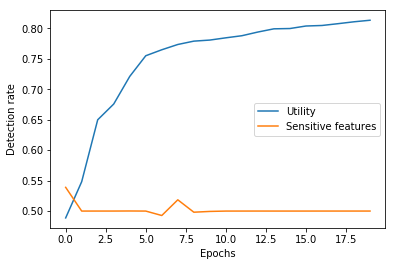

In [441]:
import matplotlib.pyplot as plt
x1 = np.arange(20)
print (len(EA))
plt.plot(x1,EA)
plt.plot(x1,PA)
plt.ylabel('Detection rate')
plt.xlabel('Epochs')
plt.legend(['Utility','Sensitive features'])
plt.show()

In [408]:
#1C

correct_predictionV = tf.equal(tf.argmax(predV, 1), tf.argmax(y[:,:10], 1))
correct_predictionU = tf.equal(tf.argmax(predU, 1), tf.argmax(y[:,10:], 1))

AccuracyU = tf.reduce_mean(tf.cast(correct_predictionU, tf.float32))
AccuracyV = tf.reduce_mean(tf.cast(correct_predictionV, tf.float32))
print ("Detection rate of Sensitive features (on Training Data):", AccuracyU.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime}))
print ("Accuracy of Utility (on Training Data):", AccuracyV.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime}))
EncTest = EncImages.eval(session=sess,feed_dict={x:XTestPrime,y:YTestPrime})


Detection rate of Sensitive features (on Training Data): 0.5
Accuracy of Utility (on Training Data): 0.833673


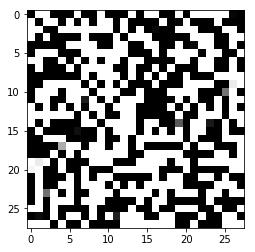

In [409]:
Temp = (EncImages.eval(session=sess,feed_dict={x:XTrainPrime[0].reshape(1,784)})).reshape((28,28))
plt.imshow(Temp, cmap='gray')
plt.show()


In [386]:
'''
Attacker has the capability to train further: Here the attacker just continues training
'''
training_epochs = 20
learning_rateV = 0.0001
learning_rateU = 0.0001

for epoch in range(training_epochs):
    avg_cost1 = 0.
    avg_cost2 = 0.
    total_batch = int(int(EncTest.shape[0])/batch_size)
    print ("Epoch=",epoch)
      
    for i in range(total_batch):

        batch_xs = EncTest[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTestPrime[(i*batch_size):((i+1)*batch_size)]
        _, c1 = sess.run([ClassifierOptimizer1, CostV], feed_dict={x: batch_xs, y: batch_ys})
        _, c2 = sess.run([ClassifierOptimizer2, CostU], feed_dict={x: batch_xs, y: batch_ys})

    #avg_cost1 += c1 / total_batch
    avg_cost2 += c2 / total_batch
    print ('Private attribute cost:',avg_cost2)
    print ('\n')
print ("Optimization Finished!")

Epoch= 0
Private attribute cost: 0.0782878923416


Epoch= 1
Private attribute cost: 0.0782878923416


Epoch= 2
Private attribute cost: 0.0782878923416


Epoch= 3
Private attribute cost: 0.0782878923416


Epoch= 4
Private attribute cost: 0.0782878923416


Epoch= 5
Private attribute cost: 0.0782878923416


Epoch= 6
Private attribute cost: 0.0782878923416


Epoch= 7
Private attribute cost: 0.0782878923416


Epoch= 8
Private attribute cost: 0.0782878923416


Epoch= 9
Private attribute cost: 0.0782878923416


Epoch= 10
Private attribute cost: 0.0782878923416


Epoch= 11
Private attribute cost: 0.0782878923416


Epoch= 12
Private attribute cost: 0.0782878923416


Epoch= 13
Private attribute cost: 0.0782878923416


Epoch= 14
Private attribute cost: 0.0782878923416


Epoch= 15
Private attribute cost: 0.0782878923416


Epoch= 16
Private attribute cost: 0.0782878923416


Epoch= 17
Private attribute cost: 0.0782878923416


Epoch= 18
Private attribute cost: 0.0782878923416


Epoch= 19
Private attr

In [402]:

#print ("Detection rate of Sensitive features (on Training Data):", AccuracyU.eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))
#print ("Detection rate of Sensitive features (on Training Data):", AccuracyU.eval(session=sess,feed_dict={EncImages: EncTest, y: YTestPrime}))



Detection rate of Sensitive features (on Training Data): 0.4


In [388]:
'''
This is an experiment not mentioned in paper. Here I assume that the attacker just received 
a bunch of encoded messages with true labels. This experiment sees if it is possible to get the images back                                                                                                                                                                                                                                         
'''
sess.close()
print ('esha')
EncImages = tf.placeholder(tf.float32,[None,784])
learning_rateV = 0.001
learning_rateU = 0.0001


W3 = tf.Variable(tf.random_normal([784, 300], mean=0, stddev=1))
b3 = tf.Variable(tf.random_normal([300], mean=0, stddev = 1))
W4 = tf.Variable(tf.random_normal([300, 10]))
b4 = tf.Variable(tf.random_normal([10]))

Hidden2 = tf.nn.relu(tf.matmul(EncImages, W3) + b3);
OutputLayer1 = tf.matmul(Hidden2, W4) + b4;
ClassifierParameters1 = [W3,b3,W4,b4]

#W5,b5,W6,b6 helps in classifying sensitive features
W5 = tf.Variable(tf.random_normal([784, 100], mean=0, stddev=1))
b5 = tf.Variable(tf.random_normal([100], mean=0, stddev = 1))
W6 = tf.Variable(tf.random_normal([100, 2]))
b6 = tf.Variable(tf.random_normal([2]))

Hidden3 = tf.nn.relu(tf.matmul(EncImages, W5) + b5);
OutputLayer2 = tf.matmul(Hidden3, W6) + b6;
ClassifierParameters2 = [W5,b5,W6,b6]
predV = tf.nn.softmax(OutputLayer1)
predU = tf.nn.softmax(OutputLayer2)

CostV = tf.reduce_mean(-tf.reduce_sum(y[:,:10]*tf.log(tf.clip_by_value(predV,1e-10,1.0)), reduction_indices=1))
CostU = tf.reduce_mean(-tf.reduce_sum(y[:,10:]*tf.log(tf.clip_by_value(predU,1e-10,1.0)), reduction_indices=1))

ClassifierOptimizer1 = tf.train.AdamOptimizer(learning_rate=learning_rateV).minimize(CostV,var_list=ClassifierParameters1)
ClassifierOptimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rateU).minimize(CostU,var_list=ClassifierParameters2)
correct_predictionV = tf.equal(tf.argmax(predV, 1), tf.argmax(y[:,:10], 1))
correct_predictionU = tf.equal(tf.argmax(predU, 1), tf.argmax(y[:,10:], 1))

AccuracyU = tf.reduce_mean(tf.cast(correct_predictionU, tf.float32))
AccuracyV = tf.reduce_mean(tf.cast(correct_predictionV, tf.float32))
sess = tf.Session()
sess.run(tf.global_variables_initializer())


training_epochs = 30
for epoch in range(training_epochs):
    avg_cost1 = 0.
    avg_cost2 = 0.
    total_batch = int(int(EncTest.shape[0])/batch_size)
    print ("Epoch=",epoch)
      
    for i in range(total_batch):

        batch_xs = EncTest[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTestPrime[(i*batch_size):((i+1)*batch_size)]
        _, c1 = sess.run([ClassifierOptimizer1, CostV], feed_dict={EncImages: batch_xs, y: batch_ys})
        _, c2 = sess.run([ClassifierOptimizer2, CostU], feed_dict={EncImages: batch_xs, y: batch_ys})

    avg_cost1 += c1 / total_batch
    avg_cost2 += c2 / total_batch
    print ('Private attribute cost:',avg_cost2)
    print ('\n')
print ("Optimization Finished!")


esha
Epoch= 0
Private attribute cost: 0.0660851430893


Epoch= 1
Private attribute cost: 0.056230931282


Epoch= 2
Private attribute cost: 0.0364993309975


Epoch= 3
Private attribute cost: 0.0251457881927


Epoch= 4
Private attribute cost: 0.0145295441151


Epoch= 5
Private attribute cost: 0.01068998456


Epoch= 6
Private attribute cost: 0.00976842880249


Epoch= 7
Private attribute cost: 0.00921287834644


Epoch= 8
Private attribute cost: 0.00783839583397


Epoch= 9
Private attribute cost: 0.00655700683594


Epoch= 10
Private attribute cost: 0.00515949428082


Epoch= 11
Private attribute cost: 0.00456365197897


Epoch= 12
Private attribute cost: 0.00423547714949


Epoch= 13
Private attribute cost: 0.00388305217028


Epoch= 14
Private attribute cost: 0.00344474673271


Epoch= 15
Private attribute cost: 0.00332902342081


Epoch= 16
Private attribute cost: 0.00320775270462


Epoch= 17
Private attribute cost: 0.00295673072338


Epoch= 18
Private attribute cost: 0.00269685298204


Epoch= 

In [389]:

print ("Detection rate of Sensitive features (on Training Data):", AccuracyU.eval(session=sess,feed_dict={EncImages: EncTest, y: YTestPrime}))
sess.close()

Detection rate of Sensitive features (on Training Data): 0.9816


As seen above although initial classifier was good in the sense it could detect only 50% of the images with sensitive attributes. However, as the attacker trains the classifier more, the capability of the sensitive attrbute classifier increases and it can now detect around 70% of the images with sensitive features

In [432]:
#2A
'''
The architecture is same but there are some added constraints. Now all the encoded images have to have zero mean 
and unit variance. This is done to not saturate the encoder to a constant solution 
'''

alpha = (1/16)

    
x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder(tf.float32, [None, 12]) # 0-9 digits recognition => 1 class


'''-----------------------------------------Encoder Training----------------------------------------------------'''
W1 = tf.Variable(tf.random_normal([784, 300], mean=0, stddev=1))
b1 = tf.Variable(tf.random_normal([300], mean=0, stddev = 1))
W2 = tf.Variable(tf.random_normal([300, 784],mean=0, stddev=1))
b2 = tf.Variable(tf.random_normal([784],mean=0, stddev=1))

Hidden1 = tf.nn.relu(tf.matmul(x, W1) + b1);
TempLayer = tf.matmul(Hidden1, W2) + b2
MeanTempLayer  = tf.reduce_mean(TempLayer)
m = tf.reduce_mean(TempLayer,axis=1)
m = tf.convert_to_tensor([m]*784)
m = tf.reshape(m,(-1,784))
VarTempLayer  = tf.reduce_mean((TempLayer-m)**2)
EncImagesTemp = tf.nn.tanh(tf.matmul(Hidden1, W2) + b2);
#These are the encodings of the images

c = tf.reduce_max(EncImagesTemp)
d = tf.reduce_min(EncImagesTemp)
#The Encodings need to be scaled so that the final values are between 0 and 1 (like original MNIST)
EncImages = tf.divide((EncImagesTemp-d),(c-d))

EncoderParameters = [W1,b1,W2,b2]
    
'''---------------------------------------Classifier Training----------------------------------------'''
#W3,b3,W4,b4 helps in classifying utility
W3 = tf.Variable(tf.random_normal([784, 300], mean=0, stddev=1))
b3 = tf.Variable(tf.random_normal([300], mean=0, stddev = 1))
W4 = tf.Variable(tf.random_normal([300, 10]))
b4 = tf.Variable(tf.random_normal([10]))

Hidden2 = tf.nn.relu(tf.matmul(EncImages, W3) + b3);
OutputLayer1 = tf.matmul(Hidden2, W4) + b4;
ClassifierParameters1 = [W3,b3,W4,b4]

#W5,b5,W6,b6 helps in classifying sensitive features
W5 = tf.Variable(tf.random_normal([784, 300], mean=0, stddev=1))
b5 = tf.Variable(tf.random_normal([300], mean=0, stddev = 1))
W6 = tf.Variable(tf.random_normal([300, 2]))
b6 = tf.Variable(tf.random_normal([2]))

Hidden3 = tf.nn.relu(tf.matmul(EncImages, W5) + b5);
OutputLayer2 = tf.matmul(Hidden3, W6) + b6;
ClassifierParameters2 = [W5,b5,W6,b6]    
  # Optimization
learning_rateU = 0.0001
learning_rateV = 0.0001
learning_rateE = 0.0001
training_epochs = 40
batch_size = 100
display_step = 1
lambda1 = 0.05
lambda2 = 0.05
print ('Entering Optimization')
    
predV = tf.nn.softmax(OutputLayer1)
predU = tf.nn.softmax(OutputLayer2)

CostV = tf.reduce_mean(-tf.reduce_sum(y[:,:10]*tf.log(tf.clip_by_value(predV,1e-10,1.0)), reduction_indices=1))
CostU = tf.reduce_mean(-tf.reduce_sum(y[:,10:]*tf.log(tf.clip_by_value(predU,1e-10,1.0)), reduction_indices=1))

#Batch normalization will happen across a batch

cost = CostU - (alpha*CostV) - (lambda1*MeanTempLayer) - lambda2*(VarTempLayer-1)

ClassifierOptimizer1 = tf.train.AdamOptimizer(learning_rate=learning_rateV).minimize(CostV,var_list=ClassifierParameters1)
ClassifierOptimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rateU).minimize(CostU,var_list=ClassifierParameters2)
EncoderOptimizer = tf.train.AdamOptimizer(learning_rate=learning_rateE).minimize(-cost,var_list=EncoderParameters)

correct_predictionV = tf.equal(tf.argmax(predV, 1), tf.argmax(y[:,:10], 1))
correct_predictionU = tf.equal(tf.argmax(predU, 1), tf.argmax(y[:,10:], 1))


AccuracyU = tf.reduce_mean(tf.cast(correct_predictionU, tf.float32))
AccuracyV = tf.reduce_mean(tf.cast(correct_predictionV, tf.float32))
#print ("Detection rate of Sensitive features (on Test Data):", AccuracyU.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime}))
#print ("Accuracy of Utility (on Test Data):", AccuracyV.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime}))

sess = tf.Session()
sess.run(tf.global_variables_initializer())




Entering Optimization


In [433]:
m = tf.reduce_mean(TempLayer,axis=1)
m = tf.convert_to_tensor([m]*784)
m = tf.reshape(m,(-1,784))
print (m.shape)
print (MeanTempLayer.shape)

(?, 784)
()


In [434]:
#1B
EA = []
PA = []

for epoch in range(training_epochs):
    avg_cost1 = 0.
    avg_cost2 = 0.
    avg_cost3 = 0.
    total_batch = int(int(XTrainPrime.shape[0])/batch_size)
    print ("Epoch=",epoch)
    
    for i in range(total_batch):
        batch_xs = XTrainPrime[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTrainPrime[(i*batch_size):((i+1)*batch_size)]
        _, c3 = sess.run([EncoderOptimizer, cost], feed_dict={x: batch_xs, y: batch_ys})
    avg_cost3 += c3 / total_batch
    print ('Encoder cost', avg_cost3) 
    
    for i in range(total_batch):

        batch_xs = XTrainPrime[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTrainPrime[(i*batch_size):((i+1)*batch_size)]
        _, c1 = sess.run([ClassifierOptimizer1, CostV], feed_dict={x: batch_xs, y: batch_ys})
        _, c2 = sess.run([ClassifierOptimizer2, CostU], feed_dict={x: batch_xs, y: batch_ys})

    avg_cost1 += c1 / total_batch
    avg_cost2 += c2 / total_batch
    print ('Utility cost:',avg_cost1,'Private attribute cost:',avg_cost2)
    EpochAccuracy = AccuracyV.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime})
    print ('Epoch Accuracy',EpochAccuracy)
    EA.append(EpochAccuracy)
    PA.append(AccuracyU.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime}))
#     if (EpochAccuracy > 0.6):
#         #print ('yippie')
#         learning_rateU = 0.001
#         learning_rateV = 0.0005
#         learning_rateE = 0.001
#     if (EpochAccuracy > 0.8):
#         #print ('yippie')
#         learning_rateU = 0.0001
#         learning_rateV = 0.0001
#         learning_rateE = 0.0005
#         alpha = 1.5
    print ('\n')
print ("Optimization Finished!")

Epoch= 0
Encoder cost -0.51255049272
Utility cost: 0.0344782326438 Private attribute cost: 0.0147616594488
Epoch Accuracy 0.194382


Epoch= 1
Encoder cost -0.327788973722
Utility cost: 0.0288886313005 Private attribute cost: 0.015831971602
Epoch Accuracy 0.259309


Epoch= 2
Encoder cost -0.233642328436
Utility cost: 0.0284949892217 Private attribute cost: 0.0183445462314
Epoch Accuracy 0.300618


Epoch= 3
Encoder cost -0.178135223389
Utility cost: 0.0293230819702 Private attribute cost: 0.0162531349876
Epoch Accuracy 0.325564


Epoch= 4
Encoder cost -0.138595095548
Utility cost: 0.0284023319591 Private attribute cost: 0.0154121052135
Epoch Accuracy 0.337855


Epoch= 5
Encoder cost -0.106044242165
Utility cost: 0.0303582000732 Private attribute cost: 0.015977973938
Epoch Accuracy 0.349691


Epoch= 6
Encoder cost -0.0872513857755
Utility cost: 0.0292016878995 Private attribute cost: 0.0162778230147
Epoch Accuracy 0.355509


Epoch= 7
Encoder cost -0.068250392567
Utility cost: 0.0296968286

40


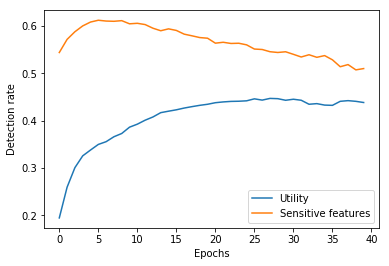

In [436]:
import matplotlib.pyplot as plt
x1 = np.arange(40)
print (len(EA))
plt.plot(x1,EA)
plt.plot(x1,PA)
plt.ylabel('Detection rate')
plt.xlabel('Epochs')
plt.legend(['Utility','Sensitive features'])
plt.show()

In [430]:

learning_rateU = 0.0001
learning_rateV = 0.0003
learning_rateE = 0.0005
training_epochs = 10
for epoch in range(training_epochs):
    avg_cost1 = 0.
    avg_cost2 = 0.
    avg_cost3 = 0.
    total_batch = int(int(XTrainPrime.shape[0])/batch_size)
    print ("Epoch=",epoch)
    
    for i in range(total_batch):
        batch_xs = XTrainPrime[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTrainPrime[(i*batch_size):((i+1)*batch_size)]
        _, c3 = sess.run([EncoderOptimizer, cost], feed_dict={x: batch_xs, y: batch_ys})
    avg_cost3 += c3 / total_batch
    print ('Encoder cost', avg_cost3) 
    
    for i in range(total_batch):

        batch_xs = XTrainPrime[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTrainPrime[(i*batch_size):((i+1)*batch_size)]
        _, c1 = sess.run([ClassifierOptimizer1, CostV], feed_dict={x: batch_xs, y: batch_ys})
        _, c2 = sess.run([ClassifierOptimizer2, CostU], feed_dict={x: batch_xs, y: batch_ys})

    avg_cost1 += c1 / total_batch
    avg_cost2 += c2 / total_batch
    print ('Utility cost:',avg_cost1,'Private attribute cost:',avg_cost2)
    EpochAccuracy = AccuracyV.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime})
    print ('Epoch Accuracy',EpochAccuracy)
    EA.append(EpochAccuracy)
    PA.append(AccuracyU.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime}))
print ('Optimization finished')

Epoch= 0


InvalidArgumentError: You must feed a value for placeholder tensor 'Placeholder_152' with dtype float and shape [?,784]
	 [[Node: Placeholder_152 = Placeholder[dtype=DT_FLOAT, shape=[?,784], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'Placeholder_152', defined at:
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\ipython-6.2.0-py3.5.egg\IPython\core\interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\ipython-6.2.0-py3.5.egg\IPython\core\interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\ipython-6.2.0-py3.5.egg\IPython\core\interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-414-27c7ada08a98>", line 10, in <module>
    x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\array_ops.py", line 1548, in placeholder
    return gen_array_ops._placeholder(dtype=dtype, shape=shape, name=name)
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 2094, in _placeholder
    name=name)
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "c:\users\userlocal\appdata\local\programs\python\python35\lib\site-packages\tensorflow\python\framework\ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'Placeholder_152' with dtype float and shape [?,784]
	 [[Node: Placeholder_152 = Placeholder[dtype=DT_FLOAT, shape=[?,784], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


### Written report till here

In [410]:
#2C
AccuracyU = tf.reduce_mean(tf.cast(correct_predictionU, tf.float32))
AccuracyV = tf.reduce_mean(tf.cast(correct_predictionV, tf.float32))
print ("Detection rate of Sensitive features (on Training Data):", AccuracyU.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime}))
print ("Accuracy of Utility (on Training Data):", AccuracyV.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime}))





Detection rate of Sensitive features (on Training Data): 0.5
Accuracy of Utility (on Training Data): 0.833673


While Utility is improving in the previous method, the encoded images look like:

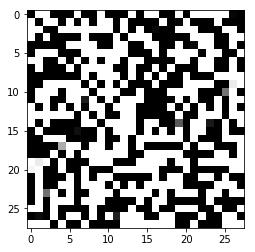

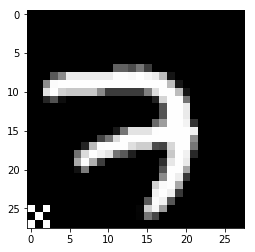

In [412]:
Temp = (EncImages.eval(session=sess,feed_dict={x:XTrainPrime[0].reshape(1,784)})).reshape((28,28))
plt.imshow(Temp, cmap='gray')
plt.show()
Temp2 = XTrainPrime[0].reshape((28,28))
plt.imshow(Temp2, cmap='gray')
plt.show()


In [238]:
training_epochs = 20
learning_rateV = 0.0001
learning_rateU = 0.0001

for epoch in range(training_epochs):
    avg_cost1 = 0.
    avg_cost2 = 0.
    total_batch = int(int(EncTest.shape[0])/batch_size)
    print ("Epoch=",epoch)
      
    for i in range(total_batch):

        batch_xs = EncTest[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTestPrime[(i*batch_size):((i+1)*batch_size)]
        _, c1 = sess.run([ClassifierOptimizer1, CostV], feed_dict={x: batch_xs, y: batch_ys})
        _, c2 = sess.run([ClassifierOptimizer2, CostU], feed_dict={x: batch_xs, y: batch_ys})

    #avg_cost1 += c1 / total_batch
    avg_cost2 += c2 / total_batch
    print ('Private attribute cost:',avg_cost2)
    print ('\n')
print ("Optimization Finished!")

print ("Detection rate of Sensitive features (on Training Data):", AccuracyU.eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))



Epoch= 0
Private attribute cost: 0.112826662064


Epoch= 1
Private attribute cost: 0.112826662064


Epoch= 2
Private attribute cost: 0.112826662064


Epoch= 3
Private attribute cost: 0.112826662064


Epoch= 4
Private attribute cost: 0.112826662064


Epoch= 5
Private attribute cost: 0.112826662064


Epoch= 6
Private attribute cost: 0.112826662064


Epoch= 7
Private attribute cost: 0.112826662064


Epoch= 8
Private attribute cost: 0.112826662064


Epoch= 9
Private attribute cost: 0.112826662064


Epoch= 10
Private attribute cost: 0.112826662064


Epoch= 11
Private attribute cost: 0.112826662064


Epoch= 12
Private attribute cost: 0.112826662064


Epoch= 13
Private attribute cost: 0.112826662064


Epoch= 14
Private attribute cost: 0.112826662064


Epoch= 15
Private attribute cost: 0.112826662064


Epoch= 16
Private attribute cost: 0.112826662064


Epoch= 17
Private attribute cost: 0.112826662064


Epoch= 18
Private attribute cost: 0.112826662064


Epoch= 19
Private attribute cost: 0.11282

In [242]:
sess.close()
print ('esha')
EncImages = tf.placeholder(tf.float32,[None,784])
learning_rateV = 0.001
learning_rateU = 0.0001


W3 = tf.Variable(tf.random_normal([784, 300], mean=0, stddev=1))
b3 = tf.Variable(tf.random_normal([300], mean=0, stddev = 1))
W4 = tf.Variable(tf.random_normal([300, 10]))
b4 = tf.Variable(tf.random_normal([10]))

Hidden2 = tf.nn.relu(tf.matmul(EncImages, W3) + b3);
OutputLayer1 = tf.matmul(Hidden2, W4) + b4;
ClassifierParameters1 = [W3,b3,W4,b4]

#W5,b5,W6,b6 helps in classifying sensitive features
W5 = tf.Variable(tf.random_normal([784, 100], mean=0, stddev=1))
b5 = tf.Variable(tf.random_normal([100], mean=0, stddev = 1))
W6 = tf.Variable(tf.random_normal([100, 2]))
b6 = tf.Variable(tf.random_normal([2]))

Hidden3 = tf.nn.relu(tf.matmul(EncImages, W5) + b5);
OutputLayer2 = tf.matmul(Hidden3, W6) + b6;
ClassifierParameters2 = [W5,b5,W6,b6]
predV = tf.nn.softmax(OutputLayer1)
predU = tf.nn.softmax(OutputLayer2)

CostV = tf.reduce_mean(-tf.reduce_sum(y[:,:10]*tf.log(tf.clip_by_value(predV,1e-10,1.0)), reduction_indices=1))
CostU = tf.reduce_mean(-tf.reduce_sum(y[:,10:]*tf.log(tf.clip_by_value(predU,1e-10,1.0)), reduction_indices=1))

ClassifierOptimizer1 = tf.train.AdamOptimizer(learning_rate=learning_rateV).minimize(CostV,var_list=ClassifierParameters1)
ClassifierOptimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rateU).minimize(CostU,var_list=ClassifierParameters2)
correct_predictionV = tf.equal(tf.argmax(predV, 1), tf.argmax(y[:,:10], 1))
correct_predictionU = tf.equal(tf.argmax(predU, 1), tf.argmax(y[:,10:], 1))

AccuracyU = tf.reduce_mean(tf.cast(correct_predictionU, tf.float32))
AccuracyV = tf.reduce_mean(tf.cast(correct_predictionV, tf.float32))
sess = tf.Session()
sess.run(tf.global_variables_initializer())


training_epochs = 20
for epoch in range(training_epochs):
    avg_cost1 = 0.
    avg_cost2 = 0.
    total_batch = int(int(EncTest.shape[0])/batch_size)
    print ("Epoch=",epoch)
      
    for i in range(total_batch):

        batch_xs = EncTest[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTestPrime[(i*batch_size):((i+1)*batch_size)]
        _, c1 = sess.run([ClassifierOptimizer1, CostV], feed_dict={EncImages: batch_xs, y: batch_ys})
        _, c2 = sess.run([ClassifierOptimizer2, CostU], feed_dict={EncImages: batch_xs, y: batch_ys})

    avg_cost1 += c1 / total_batch
    avg_cost2 += c2 / total_batch
    print ('Private attribute cost:',avg_cost2)
    print ('\n')
print ("Optimization Finished!")

print ("Detection rate of Sensitive features (on Training Data):", AccuracyU.eval(session=sess,feed_dict={EncImages: EncTest, y: YTestPrime}))


esha
Epoch= 0
Private attribute cost: 0.112826662064


Epoch= 1
Private attribute cost: 0.112826662064


Epoch= 2
Private attribute cost: 0.112826662064


Epoch= 3
Private attribute cost: 0.112826662064


Epoch= 4
Private attribute cost: 0.112826662064


Epoch= 5
Private attribute cost: 0.112826662064


Epoch= 6
Private attribute cost: 0.112826662064


Epoch= 7
Private attribute cost: 0.112826662064


Epoch= 8
Private attribute cost: 0.112826662064


Epoch= 9
Private attribute cost: 0.112826662064


Epoch= 10
Private attribute cost: 0.112826662064


Epoch= 11
Private attribute cost: 0.112826662064


Epoch= 12
Private attribute cost: 0.112826662064


Epoch= 13
Private attribute cost: 0.112826662064


Epoch= 14
Private attribute cost: 0.112826662064


Epoch= 15
Private attribute cost: 0.112826662064


Epoch= 16
Private attribute cost: 0.112826662064


Epoch= 17
Private attribute cost: 0.112826662064


Epoch= 18
Private attribute cost: 0.112826662064


Epoch= 19
Private attribute cost: 0.

In [370]:
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
XTrain = mnist.train.images
YTrain = mnist.train.labels
XTest = mnist.test.images
YTest = mnist.test.labels
def TransformMNIST (Percentage,OrigX,OrigY):

    #Choose random images to insert sensitive information
    SelectedImages = np.random.choice(int(OrigX.shape[0]),int((Percentage/100)*OrigX.shape[0]),replace=False) 
    print ('No. of images changed are', SelectedImages.shape[0]) #Choose random images to insert sensitive information

    SubX = OrigX[SelectedImages]
    SubX[:,729] = 1
    
    #Uncomment the following 4 lines if you want the flower as sensitive feature
    SubX[:,700] = 1
    SubX[:,702] = 1
    SubX[:,756] = 1
    SubX[:,758] = 1
    
    SubY = OrigY[SelectedImages]
    SenYCol = np.zeros((OrigY.shape[0],2))
    NewY = np.concatenate((OrigY,SenYCol),axis=1)

    for num,i in enumerate(SelectedImages):
        OrigX[i]=SubX[num]
        NewY[i][11]=1
    NewX = OrigX
    for i in range(int(OrigX.shape[0])):
        if i not in SelectedImages:
            NewY[i][10]=1
    return (SelectedImages, NewX,NewY)

s,XTrainPrime, YTrainPrime = TransformMNIST(50,XTrain[:15000],YTrain[:15000])
_,XTestPrime, YTestPrime = TransformMNIST(70,XTest,YTest)
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
XTrain = mnist.train.images
YTrain = mnist.train.labels
XTest = mnist.test.images
YTest = mnist.test.labels

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
No. of images changed are 7500
No. of images changed are 7000
Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


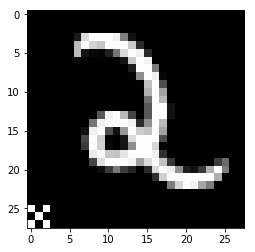

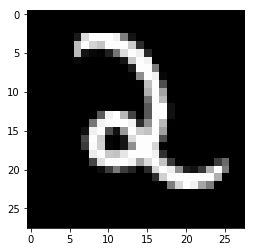

In [371]:
n=s[0]
X=XTrainPrime[n]
TempImage = X.reshape((28,28))
plt.imshow(TempImage, cmap='gray')
plt.show()
X1=XTrain[n]
TempImage1 = X1.reshape((28,28))
plt.imshow(TempImage1, cmap='gray')
plt.show()

In [ ]:
n=s[0]
X=XTrainPrime[n]
TempImage = X.reshape((28,28))
plt.imshow(TempImage, cmap='gray')
plt.show()

In [444]:
'''
The architecture is same but there are some added constraints. Now all the encoded images have to have zero mean 
and unit variance. This is done to not saturate the encoder to a constant solution and will try to look similar 
to the original digit without any attribute
'''

alpha = (1)

    
x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder(tf.float32, [None, 12]) # 0-9 digits recognition => 1 class


'''-----------------------------------------Encoder Training----------------------------------------------------'''
W1 = tf.Variable(tf.random_normal([784, 300], mean=0, stddev=1))
b1 = tf.Variable(tf.random_normal([300], mean=0, stddev = 1))
W2 = tf.Variable(tf.random_normal([300, 784],mean=0, stddev=1))
b2 = tf.Variable(tf.random_normal([784],mean=0, stddev=1))

Hidden1 = tf.nn.relu(tf.matmul(x, W1) + b1);
TempLayer = tf.matmul(Hidden1, W2) + b2
MeanTempLayer  = tf.reduce_mean(TempLayer)
m = tf.reduce_mean(TempLayer,axis=1)
m = tf.convert_to_tensor([m]*784)
m = tf.reshape(m,(-1,784))
VarTempLayer  = tf.reduce_mean((TempLayer-m)**2)
EncImagesTemp = tf.nn.tanh(tf.matmul(Hidden1, W2) + b2);
#These are the encodings of the images

c = tf.reduce_max(EncImagesTemp)
d = tf.reduce_min(EncImagesTemp)
#The Encodings need to be scaled so that the final values are between 0 and 1 (like original MNIST)
EncImages = tf.divide((EncImagesTemp-d),(c-d))
L2Norm = tf.sqrt(tf.reduce_sum((EncImages - x)**2))

EncoderParameters = [W1,b1,W2,b2]
    
'''---------------------------------------Classifier Training----------------------------------------'''
#W3,b3,W4,b4 helps in classifying utility
W3 = tf.Variable(tf.random_normal([784, 300], mean=0, stddev=1))
b3 = tf.Variable(tf.random_normal([300], mean=0, stddev = 1))
W4 = tf.Variable(tf.random_normal([300, 10]))
b4 = tf.Variable(tf.random_normal([10]))

Hidden2 = tf.nn.relu(tf.matmul(EncImages, W3) + b3);
OutputLayer1 = tf.matmul(Hidden2, W4) + b4;
ClassifierParameters1 = [W3,b3,W4,b4]

#W5,b5,W6,b6 helps in classifying sensitive features
W5 = tf.Variable(tf.random_normal([784, 300], mean=0, stddev=1))
b5 = tf.Variable(tf.random_normal([300], mean=0, stddev = 1))
W6 = tf.Variable(tf.random_normal([300, 2]))
b6 = tf.Variable(tf.random_normal([2]))

Hidden3 = tf.nn.relu(tf.matmul(EncImages, W5) + b5);
OutputLayer2 = tf.matmul(Hidden3, W6) + b6;
ClassifierParameters2 = [W5,b5,W6,b6]    
  # Optimization
learning_rateU = 0.0001
learning_rateV = 0.0003
learning_rateE = 0.0005
training_epochs = 30
batch_size = 100
display_step = 1
lambda1 = 0.05
lambda2 = 0.05
lambda3 = 0.2
print ('Entering Optimization')
    
predV = tf.nn.softmax(OutputLayer1)
predU = tf.nn.softmax(OutputLayer2)

CostV = tf.reduce_mean(-tf.reduce_sum(y[:,:10]*tf.log(tf.clip_by_value(predV,1e-10,1.0)), reduction_indices=1))
CostU = tf.reduce_mean(-tf.reduce_sum(y[:,10:]*tf.log(tf.clip_by_value(predU,1e-10,1.0)), reduction_indices=1))

#Batch normalization will happen across a batch

cost = CostU - (alpha*CostV) - (lambda1*MeanTempLayer) - lambda2*(VarTempLayer-1) - lambda3*(L2Norm)
print (MeanTempLayer,VarTempLayer,L2Norm)
ClassifierOptimizer1 = tf.train.AdamOptimizer(learning_rate=learning_rateV).minimize(CostV,var_list=ClassifierParameters1)
ClassifierOptimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rateU).minimize(CostU,var_list=ClassifierParameters2)
EncoderOptimizer = tf.train.AdamOptimizer(learning_rate=learning_rateE).minimize(-cost,var_list=EncoderParameters)

correct_predictionV = tf.equal(tf.argmax(predV, 1), tf.argmax(y[:,:10], 1))
correct_predictionU = tf.equal(tf.argmax(predU, 1), tf.argmax(y[:,10:], 1))


AccuracyU = tf.reduce_mean(tf.cast(correct_predictionU, tf.float32))
AccuracyV = tf.reduce_mean(tf.cast(correct_predictionV, tf.float32))
#print ("Detection rate of Sensitive features (on Test Data):", AccuracyU.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime}))
#print ("Accuracy of Utility (on Test Data):", AccuracyV.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime}))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

Entering Optimization
Tensor("Mean_544:0", shape=(), dtype=float32) Tensor("Mean_546:0", shape=(), dtype=float32) Tensor("Sqrt_19:0", shape=(), dtype=float32)


In [445]:
#1B
EA = []
PA = []
alpha = 0.75
training_epochs = 20
XTrial = XTrainPrime
YTrial = YTrainPrime
batch_size = 10
learning_rateU = 0.0001
learning_rateV = 0.0001
learning_rateE = 0.0005
for epoch in range(training_epochs):
    avg_cost1 = 0.
    avg_cost2 = 0.
    avg_cost3 = 0.
    total_batch = int(int(XTrial.shape[0])/batch_size)
    print ("Epoch=",epoch)
    
    for i in range(total_batch):
        batch_xs = XTrial[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTrial[(i*batch_size):((i+1)*batch_size)]
        _, c3 = sess.run([EncoderOptimizer, cost], feed_dict={x: batch_xs, y: batch_ys})
        #print (c3)
    avg_cost3 += c3 / total_batch
    print ('Encoder cost', avg_cost3) 
    
    for i in range(total_batch):

        batch_xs = XTrial[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTrial[(i*batch_size):((i+1)*batch_size)]
        _, c1 = sess.run([ClassifierOptimizer1, CostV], feed_dict={x: batch_xs, y: batch_ys})
        _, c2 = sess.run([ClassifierOptimizer2, CostU], feed_dict={x: batch_xs, y: batch_ys})
        #print (c1)
        #print (c2)
    avg_cost1 += c1 / total_batch
    avg_cost2 += c2 / total_batch
    print ('Utility cost:',avg_cost1,'Private attribute cost:',avg_cost2)
    EpochAccuracy = AccuracyV.eval(session=sess,feed_dict={x: XTrial, y: YTrial})
    SenAcc = AccuracyU.eval(session=sess,feed_dict={x: XTrial, y: YTrial})
    print ('Epoch Accuracy',EpochAccuracy)
    print ('Accuracy with which sensitive features are detected', SenAcc)
    EA.append(AccuracyV.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime}))
    PA.append(AccuracyU.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime}))
#     if (EpochAccuracy > 0.6):
#         #print ('yippie')
#         learning_rateU = 0.001
#         learning_rateV = 0.0005
#         learning_rateE = 0.001
#     if (EpochAccuracy > 0.8):
#         #print ('yippie')
#         learning_rateU = 0.0001
#         learning_rateV = 0.0001
#         learning_rateE = 0.0005
#         alpha = 1.5
    print ('\n')
print ("Optimization Finished!")
correct_predictionV = tf.equal(tf.argmax(predV, 1), tf.argmax(y[:,:10], 1))
correct_predictionU = tf.equal(tf.argmax(predU, 1), tf.argmax(y[:,10:], 1))

#print ((tf.argmax(y[:,10:], 1)).eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))
#a=(tf.argmax(predU, 1)).eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime})
#print (XTestPrime.shape)

AccuracyU = tf.reduce_mean(tf.cast(correct_predictionU, tf.float32))
AccuracyV = tf.reduce_mean(tf.cast(correct_predictionV, tf.float32))
print ("Detection rate of Sensitive features (on Test Data):", AccuracyU.eval(session=sess,feed_dict={x: XTrial, y: YTrial}))
print ("Accuracy of Utility (on Training Data):", AccuracyV.eval(session=sess,feed_dict={x: XTrial, y: YTrial}))

Epoch= 0
Encoder cost -0.00604806587913
Utility cost: 0.00209325911782 Private attribute cost: 0.00251191104542
Epoch Accuracy 0.369291
Accuracy with which sensitive features are detected 0.499782


Epoch= 1
Encoder cost -0.00306634348089
Utility cost: 0.00209325911782 Private attribute cost: 0.00251191104542
Epoch Accuracy 0.426509
Accuracy with which sensitive features are detected 0.499982


Epoch= 2
Encoder cost -0.00186189478094
Utility cost: 0.00167460736361 Private attribute cost: 0.00251191104542
Epoch Accuracy 0.411582
Accuracy with which sensitive features are detected 0.500018


Epoch= 3
Encoder cost -0.00141085485979
Utility cost: 0.00167460736361 Private attribute cost: 0.00251191104542
Epoch Accuracy 0.379891
Accuracy with which sensitive features are detected 0.499964


Epoch= 4
Encoder cost -0.00161963272095
Utility cost: 0.00251191104542 Private attribute cost: 0.00251191104542
Epoch Accuracy 0.366273
Accuracy with which sensitive features are detected 0.5


Epoch= 5
E

KeyboardInterrupt: 

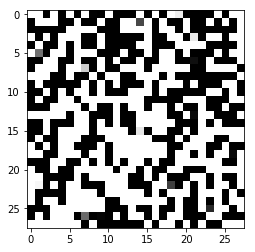

In [442]:
Temp = (EncImages.eval(session=sess,feed_dict={x:XTrainPrime[1].reshape(1,784)})).reshape((28,28))
plt.imshow(Temp, cmap='gray')
plt.show()


In [259]:
#3C
correct_predictionV = tf.equal(tf.argmax(predV, 1), tf.argmax(y[:,:10], 1))
correct_predictionU = tf.equal(tf.argmax(predU, 1), tf.argmax(y[:,10:], 1))

#print ((tf.argmax(y[:,10:], 1)).eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))
#a=(tf.argmax(predU, 1)).eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime})
#print (XTestPrime.shape)

AccuracyU = tf.reduce_mean(tf.cast(correct_predictionU, tf.float32))
AccuracyV = tf.reduce_mean(tf.cast(correct_predictionV, tf.float32))
print ("Detection rate of Sensitive features (on Test Data):", AccuracyU.eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))
print ("Accuracy of Utility (on Test Data):", AccuracyV.eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))





Detection rate of Sensitive features (on Test Data): 0.4706
Accuracy of Utility (on Test Data): 0.0947


### New encoded images

In [ ]:

n=s[0]
temp1 = XTrainPrime[n].reshape((1,784))
temp2 = temp1.reshape((28,28))
X=EncImages.eval(session=sess,feed_dict={x:temp1})
TempImage = X.reshape((28,28))
plt.imshow(temp2, cmap='gray')
plt.show()
plt.imshow(TempImage, cmap='gray')
plt.show()
distance = np.sqrt(np.sum((X-temp1)**2))
print ("Difference between encoded and original image is", distance)
# result shows this needs improvement

In [ ]:
X=EncImages.eval(session=sess,feed_dict={x:temp1})
NewX = X[0]
#print (NewX)
for num, pixel in enumerate(X[0]):
    if pixel <=2e-1:
        #print (num)
        NewX[num] = 0
    elif pixel > 3e-1 and pixel <= 5e-1:
        NewX[num] = 0.5
        #print ('yes')
    else:
        NewX[num] = 1
TempImage = NewX.reshape((28,28))
plt.imshow(TempImage, cmap='gray')
plt.show()





In [ ]:
X=EncImages.eval(session=sess,feed_dict={x:temp1})
print (X.shape)

In [ ]:
'''
The small amount of features selected 5/784 is not enough to make the neural network understand that there is some special feature residing
So I make the sensitive features a little more broad.
Here I transform the MNIST dataset for a few of them to have opposite background as the original
'''
XTrain = mnist.train.images[:1000]
YTrain = mnist.train.labels[:1000]
XTest = mnist.test.images[:1000]
YTest = mnist.test.labels[:1000]
def BWTransformMNIST (Percentage,OrigX,OrigY):
    SelectedImages = np.random.choice(int(OrigX.shape[0]),int((Percentage/100)*OrigX.shape[0]),replace=False) #Choose random images to insert sensitive information
    print ('No. of images changed are', SelectedImages.shape[0])
    SubX = 1-OrigX[SelectedImages]
    
    
    SubY = OrigY[SelectedImages]
    SenYCol = np.zeros((OrigY.shape[0],2))
    NewY = np.concatenate((OrigY,SenYCol),axis=1)

    for num,i in enumerate(SelectedImages):
        OrigX[i]=SubX[num]
        NewY[i][11]=1
    NewX = OrigX
    for i in range(int(OrigX.shape[0])):
        if i not in SelectedImages:
            NewY[i][10]=1
    return (SelectedImages, NewX,NewY)

s,XTrainPrime, YTrainPrime = BWTransformMNIST(80,XTrain,YTrain)
_,XTestPrime, YTestPrime = BWTransformMNIST(30,XTest,YTest)
XTrain = mnist.train.images[:1000]
YTrain = mnist.train.labels[:1000]
XTest = mnist.test.images[:1000]
YTest = mnist.test.labels[:1000]

In [ ]:
n=s[0]
X=XTrainPrime[n]
TempImage = X.reshape((28,28))
plt.imshow(TempImage, cmap='gray')
plt.show()

In [446]:
#4A
#Use CNN instead of regular DNN
x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder(tf.float32, [None, 12]) # 0-9 digits recognition => 1 class + verification of sensitive information


'''-----------------------------------------Encoder Training----------------------------------------------------'''
input_layer = tf.reshape(x,[-1, 28, 28, 1])    #-1 infers the shape according to the batch size user gives

  # Convolutional Layer #1
Econv1Temp = tf.layers.conv2d(
    inputs=input_layer,
    filters=1,
    kernel_size=[3, 3],
    padding="same",
    activation=None,
    reuse=None,
    name=None)
    
Econv1BN = tf.layers.batch_normalization(
    inputs=Econv1Temp,
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    reuse=None)
    
Econv1 = tf.nn.relu(Econv1BN)

Econv2Temp = tf.layers.conv2d(
    inputs=Econv1,
    filters=1,
    kernel_size=[3, 3],
    padding="same",
    activation=None,
    reuse=None)
    
Econv2BN = tf.layers.batch_normalization(
    inputs=Econv2Temp,
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    reuse=None)
    
EncImagesTemp = tf.nn.relu(Econv2BN)

c = tf.reduce_max(EncImagesTemp)
d = tf.reduce_min(EncImagesTemp)
#The Encodings need to be scaled so that the final values are between 0 and 1 (like original MNIST)
EncImages = tf.divide((EncImagesTemp-d),(c-d))
#EncoderParameters = [W1,b1,W2,b2,W3,b3]
EncoderParameters = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
    
'''---------------------------------------Classifier Training----------------------------------------'''
InputLayer = tf.reshape(EncImages,[-1, 28, 28, 1]) 
print ("One")
    #-1 infers the shape according to the batch size user gives

  # Convolutional Layer #1
Cconv1Temp = tf.layers.conv2d(
inputs=InputLayer,
filters=1,
kernel_size=[3, 3],
padding="same",
activation=None)
    
Cconv1BN = tf.layers.batch_normalization(
inputs=Cconv1Temp,
axis=-1,
momentum=0.99,
epsilon=0.001,trainable=True)
    
Cconv1 = tf.nn.relu(Cconv1BN)
Cfc3 = tf.layers.dense(inputs=Cconv1,units=1000,activation=tf.nn.relu)
dim = int(Cfc3.shape[1]*Cfc3.shape[2]*Cfc3.shape[3])
Cfc3Flat = tf.reshape(Cfc3,[-1,dim])
    #print (fc3Flat.shape)
    
  # Fully Connected Layer #1
OutputLayer1 = tf.layers.dense(inputs=Cfc3Flat,units=10,activation=None)
EncoderLen = len(EncoderParameters)
ClassifierParameters1 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[EncoderLen:]

  # Convolutional Layer #1
Cconv2Temp = tf.layers.conv2d(
inputs=InputLayer,
filters=1,
kernel_size=[3, 3],
padding="same",
activation=None)
    
Cconv2BN = tf.layers.batch_normalization(
inputs=Cconv1Temp,
axis=-1,
momentum=0.99,
epsilon=0.001,trainable=True)
    
Cconv2 = tf.nn.relu(Cconv1BN)
Cfc3 = tf.layers.dense(inputs=Cconv2,units=300,activation=tf.nn.relu)
dim = int(Cfc3.shape[1]*Cfc3.shape[2]*Cfc3.shape[3])
Cfc3Flat = tf.reshape(Cfc3,[-1,dim])
    #print (fc3Flat.shape)
    
  # Fully Connected Layer #1
OutputLayer2 = tf.layers.dense(inputs=Cfc3Flat,units=2,activation=None)
Classifier1Len = len(ClassifierParameters1)
ClassifierParameters2 = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)[Classifier1Len:]


#print (ClassifierParameters)
    
  # Optimization
learning_rateU = 0.0001
learning_rateV = 0.0001
learning_rateE1 = 0.0001
training_epochs = 10
batch_size = 100
alpha = 1/16
beta = 1
print ('Entering Optimization')
    
predV = tf.nn.tanh(OutputLayer1)
predU = tf.nn.tanh(OutputLayer2)

CostV = tf.reduce_mean(-tf.reduce_sum(y[:,:10]*tf.log(tf.clip_by_value(predV,1e-5,1.0)), reduction_indices=1))
CostU = tf.reduce_mean(-tf.reduce_sum(y[:,10:]*tf.log(tf.clip_by_value(predU,1e-5,1.0)), reduction_indices=1))


cost = CostU - (alpha*CostV)
#LookSimilarCost = tf.sqrt(tf.reduce_sum((x-EncImages)**2))

ClassifierOptimizer1 = tf.train.AdamOptimizer(learning_rate=learning_rateU).minimize(CostU,var_list=ClassifierParameters2)
ClassifierOptimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rateV).minimize(CostV,var_list=ClassifierParameters1)
EncoderOptimizer1 = tf.train.AdamOptimizer(learning_rate=learning_rateE1).minimize(-cost,var_list=EncoderParameters)
#EncoderOptimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rateE2).minimize(-cost,var_list=EncoderParameters)
correct_predictionV = tf.equal(tf.argmax(predV, 1), tf.argmax(y[:,:10], 1))
correct_predictionU = tf.equal(tf.argmax(predU, 1), tf.argmax(y[:,10:], 1))

#print ((tf.argmax(y[:,10:], 1)).eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))
#a=(tf.argmax(predU, 1)).eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime})
#print (XTestPrime.shape)

AccuracyU = tf.reduce_mean(tf.cast(correct_predictionU, tf.float32))
AccuracyV = tf.reduce_mean(tf.cast(correct_predictionV, tf.float32))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

One
Entering Optimization


In [448]:
#4B
#XTrial = XTrainPrime[:100]
#YTrial = YTrainPrime[:100]
for epoch in range(training_epochs):
    avg_cost1 = 0.
    avg_cost2 = 0.
    avg_cost3 = 0.
    avg_cost4 = 0.
    total_batch = int(int(XTrainPrime.shape[0])/batch_size)
    print ("Epoch=",epoch,'\n')
    #print (total_batch)
    for i in range(total_batch):
        #print ('i=',i)
        batch_xs = XTrainPrime[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTrainPrime[(i*batch_size):((i+1)*batch_size)]
        _, c3 = sess.run([EncoderOptimizer1, cost], feed_dict={x: batch_xs, y: batch_ys})
        #_, c4 = sess.run([EncoderOptimizer2, LookSimilarCost], feed_dict={x: batch_xs, y: batch_ys})
    avg_cost3 += c3 / total_batch
    #avg_cost4 += c4 / total_batch
    print (avg_cost3) 
    
    for i in range(total_batch):
        #print ('i=',i)
        batch_xs = XTrainPrime[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTrainPrime[(i*batch_size):((i+1)*batch_size)]
        _, c2 = sess.run([ClassifierOptimizer1, CostV], feed_dict={x: batch_xs, y: batch_ys})
        _, c1 = sess.run([ClassifierOptimizer2, CostU], feed_dict={x: batch_xs, y: batch_ys})

    avg_cost1 += c1 / total_batch
    avg_cost2 += c2 / total_batch

    print (avg_cost1,avg_cost2)
    #print (avg_cost3)
    print ("Detection rate of Sensitive features (on Test Data):", AccuracyU.eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))
    print ("Accuracy of Utility (on Test Data):", AccuracyV.eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))

    #if (epoch+1) % display_step == 0:

#        print ("Epoch:", '%04d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

print ("Optimization Finished!")

Epoch= 0 

0.0177874946594
2.70909883759e-06 7.23168116317e-07
Detection rate of Sensitive features (on Test Data): 0.3857
Accuracy of Utility (on Test Data): 0.1135
Epoch= 1 

2.68004241992e-06
5.77468202788e-07 1.66490949182e-07
Detection rate of Sensitive features (on Test Data): 0.3841
Accuracy of Utility (on Test Data): 0.1135
Epoch= 2 

5.67494214258e-07
2.18969296177e-07 6.74598016882e-08
Detection rate of Sensitive features (on Test Data): 0.3892
Accuracy of Utility (on Test Data): 0.1135
Epoch= 3 

2.14991781501e-07
1.0410847608e-07 3.35816168279e-08
Detection rate of Sensitive features (on Test Data): 0.393
Accuracy of Utility (on Test Data): 0.1135
Epoch= 4 

1.02133853943e-07
5.68723970156e-08 1.90432580315e-08
Detection rate of Sensitive features (on Test Data): 0.395
Accuracy of Utility (on Test Data): 0.1135
Epoch= 5 

5.57518267835e-08
3.37658043877e-08 1.17334887115e-08
Detection rate of Sensitive features (on Test Data): 0.3967
Accuracy of Utility (on Test Data): 0.11

KeyboardInterrupt: 

In [ ]:
#4C
correct_predictionV = tf.equal(tf.argmax(predV, 1), tf.argmax(y[:,:10], 1))
correct_predictionU = tf.equal(tf.argmax(predU, 1), tf.argmax(y[:,10:], 1))

#print ((tf.argmax(y[:,10:], 1)).eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))
#a=(tf.argmax(predU, 1)).eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime})
#print (XTestPrime.shape)

AccuracyU = tf.reduce_mean(tf.cast(correct_predictionU, tf.float32))
AccuracyV = tf.reduce_mean(tf.cast(correct_predictionV, tf.float32))
print ("Detection rate of Sensitive features (on Test Data):", AccuracyU.eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))
print ("Accuracy of Utility (on Test Data):", AccuracyV.eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))





In [ ]:
n=s[0]
temp1 = XTrainPrime[n].reshape((1,784))
temp2 = temp1.reshape((28,28))
X=EncImages.eval(session=sess,feed_dict={x:temp1})
TempImage = X.reshape((28,28))
plt.imshow(temp2, cmap='gray')
plt.show()
plt.imshow(TempImage, cmap='gray')
plt.show()
distance = np.sqrt(np.sum((X-temp1)**2))
print ("Difference between encoded and original image is", distance)

In [ ]:
#3A

alpha = (1/16)
SensitiveLabels = YTrial[:,10:12]
    
x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder(tf.float32, [None, 12]) # 0-9 digits recognition => 1 class


'''-----------------------------------------Encoder Training----------------------------------------------------'''
W1 = tf.Variable(tf.random_normal([784, 500], mean=0, stddev=1))
b1 = tf.Variable(tf.random_normal([500], mean=0, stddev = 1))
W2 = tf.Variable(tf.random_normal([500, 1000],mean=0, stddev=1))
b2 = tf.Variable(tf.random_normal([1000],mean=0, stddev=1))

W3 = tf.Variable(tf.random_normal([1000, 784], mean=0, stddev=1))
b3 = tf.Variable(tf.random_normal([784], mean=0, stddev = 1))


Hidden1 = tf.nn.relu(tf.matmul(x, W1) + b1);
Hidden3 = tf.nn.relu(tf.matmul(Hidden1, W2) + b2);
EncImagesTemp = tf.nn.relu(tf.matmul(Hidden3, W3) + b3);

c = tf.reduce_max(EncImagesTemp)
d = tf.reduce_min(EncImagesTemp)
EncImages = tf.divide(EncImagesTemp,(c-d))
EncoderParameters = [W1,b1,W2,b2,W3,b3]
    
'''---------------------------------------Classifier Training----------------------------------------'''
W4 = tf.Variable(tf.random_normal([784, 300], mean=0, stddev=1))
b4 = tf.Variable(tf.random_normal([300], mean=0, stddev = 1))


W5 = tf.Variable(tf.random_normal([300, 10],mean=0, stddev=1))
b5 = tf.Variable(tf.random_normal([10],mean=0, stddev=1))

W6 = tf.Variable(tf.random_normal([300, 2],mean=0, stddev=1))
b6 = tf.Variable(tf.random_normal([2],mean=0, stddev=1))

Hidden2 = tf.nn.relu(tf.matmul(EncImages, W4) + b4);
OutputLayer1 = tf.matmul(Hidden2, W5) + b5;
OutputLayer2 = tf.matmul(Hidden2, W6) + b6;
ClassifierParameters1 = [W4,b4,W5,b5]
ClassifierParameters2 = [W3,b3,W6,b6]
#print (ClassifierParameters)
    
  # Optimization
learning_rateU = 0.001
learning_rateV = 0.001
learning_rateE1 = 0.001
learning_rateE2 = 0.001
training_epochs = 10
batch_size = 100
display_step = 1
lambda1 = 1
lambda2 = 1
print ('Entering Optimization')
    
predV = tf.nn.softmax(OutputLayer1)
predU = tf.nn.softmax(OutputLayer2)

CostV = tf.reduce_mean(-tf.reduce_sum(y[:,:10]*tf.log(tf.clip_by_value(predV,1e-5,1.0)), reduction_indices=1))
CostU = tf.reduce_mean(-tf.reduce_sum(y[:,10:]*tf.log(tf.clip_by_value(predU,1e-5,1.0)), reduction_indices=1))

var = tf.reduce_mean(tf.reduce_mean(EncImages**2,reduction_indices=1))
#cost = CostU - (alpha*CostV)
cost = CostU - (alpha*CostV)
#LookSimilarCost = tf.sqrt(tf.reduce_sum((x-EncImages)**2))

ClassifierOptimizer1 = tf.train.AdamOptimizer(learning_rate=learning_rateU).minimize(CostU,var_list=ClassifierParameters2)
ClassifierOptimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rateV).minimize(CostV,var_list=ClassifierParameters1)
EncoderOptimizer1 = tf.train.AdamOptimizer(learning_rate=learning_rateE1).minimize(-cost,var_list=EncoderParameters)
#EncoderOptimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rateE2).minimize(LookSimilarCost,var_list=EncoderParameters)
correct_predictionV = tf.equal(tf.argmax(predV, 1), tf.argmax(y[:,:10], 1))
correct_predictionU = tf.equal(tf.argmax(predU, 1), tf.argmax(y[:,10:], 1))

#print ((tf.argmax(y[:,10:], 1)).eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))
#a=(tf.argmax(predU, 1)).eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime})
#print (XTestPrime.shape)

AccuracyU = tf.reduce_mean(tf.cast(correct_predictionU, tf.float32))
AccuracyV = tf.reduce_mean(tf.cast(correct_predictionV, tf.float32))

sess = tf.Session()
sess.run(tf.global_variables_initializer())




In [ ]:
#3B
for epoch in range(training_epochs):
    avg_cost1 = 0.
    avg_cost2 = 0.
    avg_cost3 = 0.
    avg_cost4 = 0.
    total_batch = int(int(XTrainPrime.shape[0])/batch_size)
    print ("Epoch=",epoch,'\n')
    for i in range(total_batch):
        batch_xs = XTrainPrime[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTrainPrime[(i*batch_size):((i+1)*batch_size)]
        _, c3 = sess.run([EncoderOptimizer1, cost], feed_dict={x: batch_xs, y: batch_ys})
        #_, c4 = sess.run([EncoderOptimizer2, LookSimilarCost], feed_dict={x: batch_xs, y: batch_ys})
    avg_cost3 += c3 / total_batch
    avg_cost4 += c4 / total_batch
    print (avg_cost3) 
    
    for i in range(total_batch):
        #print ('i=',i)
        batch_xs = XTrainPrime[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTrainPrime[(i*batch_size):((i+1)*batch_size)]
        _, c2 = sess.run([ClassifierOptimizer1, CostV], feed_dict={x: batch_xs, y: batch_ys})
        _, c1 = sess.run([ClassifierOptimizer2, CostU], feed_dict={x: batch_xs, y: batch_ys})

    avg_cost1 += c1 / total_batch
    avg_cost2 += c2 / total_batch

    print (avg_cost1,avg_cost2)
    print ("Detection rate of Sensitive features (on Test Data):", AccuracyU.eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))
    print ("Accuracy of Utility (on Test Data):", AccuracyV.eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))

print ("Optimization Finished!")


In [ ]:
#3C
correct_predictionV = tf.equal(tf.argmax(predV, 1), tf.argmax(y[:,:10], 1))
correct_predictionU = tf.equal(tf.argmax(predU, 1), tf.argmax(y[:,10:], 1))

#print ((tf.argmax(y[:,10:], 1)).eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))
#a=(tf.argmax(predU, 1)).eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime})
#print (XTestPrime.shape)

AccuracyU = tf.reduce_mean(tf.cast(correct_predictionU, tf.float32))
AccuracyV = tf.reduce_mean(tf.cast(correct_predictionV, tf.float32))
print ("Detection rate of Sensitive features (on Test Data):", AccuracyU.eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))
print ("Accuracy of Utility (on Test Data):", AccuracyV.eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))





In [ ]:
n=s[0]
temp1 = XTrainPrime[n].reshape((1,784))
temp2 = temp1.reshape((28,28))
X=EncImages.eval(session=sess,feed_dict={x:temp1})
TempImage = X.reshape((28,28))
plt.imshow(temp2, cmap='gray')
plt.show()
plt.imshow(TempImage, cmap='gray')
plt.show()
distance = np.sqrt(np.sum((X-temp1)**2))
print ("Difference between encoded and original image is", distance)

In [ ]:
print (EncImages.shape)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


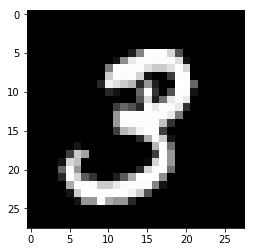

In [290]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
XTrain = mnist.train.images
YTrain = mnist.train.labels
XTest = mnist.test.images
YTest = mnist.test.labels

X=XTrain[1]
TempImage = X.reshape((28,28))
plt.imshow(TempImage, cmap='gray')
plt.show()

In [477]:
'''
     /
    /
\  /
 \/
'''
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
XTrain = mnist.train.images
YTrain = mnist.train.labels
XTest = mnist.test.images
YTest = mnist.test.labels
# Another kind of dataset
def MoreTransformMNIST (OrigX,OrigY):


    samples = int(OrigX.shape[0])
    SelectedImages = np.random.choice(samples,int(OrigX.shape[0]),replace=False) #Choose random images to insert sensitive information

    print ('No. of images changed are', SelectedImages.shape[0])
    s = SelectedImages.shape[0]
    SelectedImages1 = SelectedImages[:int(s/2)]
    SelectedImages2 = SelectedImages[int(s/2):]
    
    SubX1 = OrigX[SelectedImages1]
    SubX2 = OrigX[SelectedImages2]
    for o in range(784):
        if o % 13 == 0:
            SubX1[:,o] = 1
        if (o%10) == 0:               
            SubX2[:,o] = 1
        #elif o>=364 and o<378:
        #    SubX1[:,o] = 1



    
    
    SenYCol = np.zeros((OrigY.shape[0],2))
    NewY = np.concatenate((OrigY,SenYCol),axis=1)
    NewX = OrigX
# If plus sign then Y = 01 else Y = 10
    for num,i in enumerate(SelectedImages1):
        NewX[i]=SubX1[num]
        NewY[i][11]=1
    for num,i in enumerate(SelectedImages2):
        NewX[i]=SubX2[num]
        NewY[i][10]=1
    return (SelectedImages1, SelectedImages2, NewX, NewY)

s1,s2,XTrainPrime, YTrainPrime = MoreTransformMNIST(XTrain,YTrain)
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
XTrain = mnist.train.images
YTrain = mnist.train.labels
XTest = mnist.test.images
YTest = mnist.test.labels
# _,XTestPrime, YTestPrime = MoreTransformMNIST(30,XTest,YTest)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
No. of images changed are 55000
Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [325]:
s2[0]

3

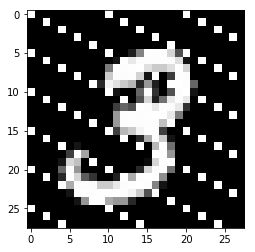

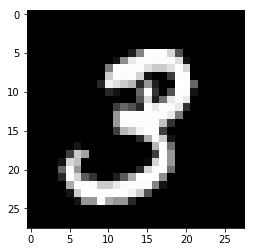

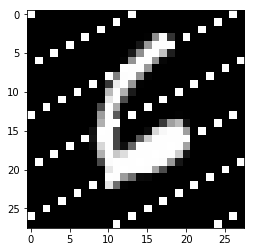

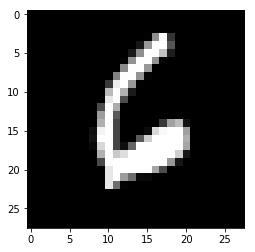

In [341]:
n=s2[0]
X=XTrainPrime[n]
TempImage = X.reshape((28,28))
plt.imshow(TempImage, cmap='gray')
plt.show()
X1=XTrain[n]
TempImage1 = X1.reshape((28,28))
plt.imshow(TempImage1, cmap='gray')
plt.show()
m=s1[0]
X=XTrainPrime[m]
TempImage = X.reshape((28,28))
plt.imshow(TempImage, cmap='gray')
plt.show()
X1=XTrain[m]
TempImage1 = X1.reshape((28,28))
plt.imshow(TempImage1, cmap='gray')
plt.show()

In [483]:
'''
The architecture is same but there are some added constraints. Now all the encoded images have to have zero mean 
and unit variance. This is done to not saturate the encoder to a constant solution and will try to look similar 
to the original digit without any attribute.
But doing the training on a new dataset
'''

alpha = (1)

    
x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder(tf.float32, [None, 12]) # 0-9 digits recognition => 1 class


'''-----------------------------------------Encoder Training----------------------------------------------------'''
W1 = tf.Variable(tf.random_normal([784, 300], mean=0, stddev=1))
b1 = tf.Variable(tf.random_normal([300], mean=0, stddev = 1))
W2 = tf.Variable(tf.random_normal([300, 784],mean=0, stddev=1))
b2 = tf.Variable(tf.random_normal([784],mean=0, stddev=1))

Hidden1 = tf.nn.relu(tf.matmul(x, W1) + b1);
TempLayer = tf.matmul(Hidden1, W2) + b2
MeanTempLayer  = tf.reduce_mean(TempLayer)
m = tf.reduce_mean(TempLayer,axis=1)
m = tf.convert_to_tensor([m]*784)
m = tf.reshape(m,(-1,784))
VarTempLayer  = tf.reduce_mean((TempLayer-m)**2)
EncImagesTemp = tf.nn.tanh(tf.matmul(Hidden1, W2) + b2);
#These are the encodings of the images

c = tf.reduce_max(EncImagesTemp)
d = tf.reduce_min(EncImagesTemp)
#The Encodings need to be scaled so that the final values are between 0 and 1 (like original MNIST)
EncImages = tf.divide((EncImagesTemp-d),(c-d))
L2Norm = tf.sqrt(tf.reduce_sum((EncImages - x)**2))

EncoderParameters = [W1,b1,W2,b2]
    
'''---------------------------------------Classifier Training----------------------------------------'''
#W3,b3,W4,b4 helps in classifying utility
W3 = tf.Variable(tf.random_normal([784, 300], mean=0, stddev=1))
b3 = tf.Variable(tf.random_normal([300], mean=0, stddev = 1))
W4 = tf.Variable(tf.random_normal([300, 10]))
b4 = tf.Variable(tf.random_normal([10]))

Hidden2 = tf.nn.relu(tf.matmul(EncImages, W3) + b3);
OutputLayer1 = tf.matmul(Hidden2, W4) + b4;
ClassifierParameters1 = [W3,b3,W4,b4]

#W5,b5,W6,b6 helps in classifying sensitive features
W5 = tf.Variable(tf.random_normal([784, 300], mean=0, stddev=1))
b5 = tf.Variable(tf.random_normal([300], mean=0, stddev = 1))
W6 = tf.Variable(tf.random_normal([300, 2]))
b6 = tf.Variable(tf.random_normal([2]))

Hidden3 = tf.nn.relu(tf.matmul(EncImages, W5) + b5);
OutputLayer2 = tf.matmul(Hidden3, W6) + b6;
ClassifierParameters2 = [W5,b5,W6,b6]    
  # Optimization
learning_rateU = 0.0001
learning_rateV = 0.0003
learning_rateE = 0.0005
training_epochs = 30
batch_size = 100
display_step = 1
lambda1 = 0.05
lambda2 = 0.05
lambda3 = 0.05
print ('Entering Optimization')
    
predV = tf.nn.softmax(OutputLayer1)
predU = tf.nn.softmax(OutputLayer2)

CostV = tf.reduce_mean(-tf.reduce_sum(y[:,:10]*tf.log(tf.clip_by_value(predV,1e-10,1.0)), reduction_indices=1))
CostU = tf.reduce_mean(-tf.reduce_sum(y[:,10:]*tf.log(tf.clip_by_value(predU,1e-10,1.0)), reduction_indices=1))

#Batch normalization will happen across a batch

#cost = CostU - (alpha*CostV) - (lambda1*MeanTempLayer) - lambda2*(VarTempLayer-1) - lambda3*(L2Norm)
cost = CostU - (alpha*CostV)- lambda3*(L2Norm)
#print (MeanTempLayer,VarTempLayer,L2Norm)
ClassifierOptimizer1 = tf.train.AdamOptimizer(learning_rate=learning_rateV).minimize(CostV,var_list=ClassifierParameters1)
ClassifierOptimizer2 = tf.train.AdamOptimizer(learning_rate=learning_rateU).minimize(CostU,var_list=ClassifierParameters2)
EncoderOptimizer = tf.train.AdamOptimizer(learning_rate=learning_rateE).minimize(-cost,var_list=EncoderParameters)

correct_predictionV = tf.equal(tf.argmax(predV, 1), tf.argmax(y[:,:10], 1))
correct_predictionU = tf.equal(tf.argmax(predU, 1), tf.argmax(y[:,10:], 1))


AccuracyU = tf.reduce_mean(tf.cast(correct_predictionU, tf.float32))
AccuracyV = tf.reduce_mean(tf.cast(correct_predictionV, tf.float32))
#print ("Detection rate of Sensitive features (on Test Data):", AccuracyU.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime}))
#print ("Accuracy of Utility (on Test Data):", AccuracyV.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime}))

sess = tf.Session()
sess.run(tf.global_variables_initializer())

Entering Optimization


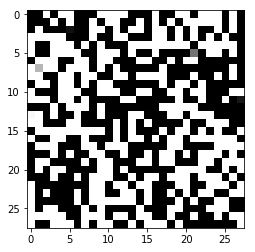

In [468]:
p=EncImages.eval(session=sess,feed_dict={x:XTrainPrime,y:YTrainPrime})
q=p[0].reshape((28,28))
_, c3 = sess.run([EncoderOptimizer, cost], feed_dict={x: batch_xs, y: batch_ys})
plt.imshow(q, cmap='gray')
plt.show()


In [487]:
#1B
EA = []
PA = []
alpha = 2
lambda3 = 0.05
training_epochs = 10
XTrial = XTrainPrime
YTrial = YTrainPrime
batch_size = 100
learning_rateU = 0.0001
learning_rateV = 0.0006
learning_rateE = 0.0003
for epoch in range(training_epochs):
    avg_cost1 = 0.
    avg_cost2 = 0.
    avg_cost3 = 0.
    total_batch = int(int(XTrainPrime.shape[0])/batch_size)
    print (total_batch)
    print ("Epoch=",epoch)
    
    for i in range(total_batch):
        #print ('esha')
        batch_xs = XTrainPrime[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTrainPrime[(i*batch_size):((i+1)*batch_size)]
        _, c3 = sess.run([EncoderOptimizer, cost], feed_dict={x: batch_xs, y: batch_ys})
        #print (c3)
    avg_cost3 += c3 / total_batch
    print ('Encoder cost', avg_cost3) 
    
    for i in range(total_batch):

        batch_xs = XTrainPrime[(i*batch_size):((i+1)*batch_size)]
        batch_ys = YTrainPrime[(i*batch_size):((i+1)*batch_size)]
        _, c1 = sess.run([ClassifierOptimizer1, CostV], feed_dict={x: batch_xs, y: batch_ys})
        _, c2 = sess.run([ClassifierOptimizer2, CostU], feed_dict={x: batch_xs, y: batch_ys})
        #print (c1)
        #print (c2)
    avg_cost1 += c1 / total_batch
    avg_cost2 += c2 / total_batch
    print ('Utility cost:',avg_cost1,'Private attribute cost:',avg_cost2)
    EpochAccuracy = AccuracyV.eval(session=sess,feed_dict={x: XTrial, y: YTrial})
    SenAcc = AccuracyU.eval(session=sess,feed_dict={x: XTrial, y: YTrial})
    print ('Epoch Accuracy',EpochAccuracy)
    print ('Accuracy with which sensitive features are detected', SenAcc)
    EA.append(AccuracyV.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime}))
    PA.append(AccuracyU.eval(session=sess,feed_dict={x: XTrainPrime, y: YTrainPrime}))
#     if (EpochAccuracy > 0.6):
#         #print ('yippie')
#         learning_rateU = 0.001
#         learning_rateV = 0.0005
#         learning_rateE = 0.001
#     if (EpochAccuracy > 0.8):
#         #print ('yippie')
#         learning_rateU = 0.0001
#         learning_rateV = 0.0001
#         learning_rateE = 0.0005
#         alpha = 1.5
    print ('\n')
print ("Optimization Finished!")
correct_predictionV = tf.equal(tf.argmax(predV, 1), tf.argmax(y[:,:10], 1))
correct_predictionU = tf.equal(tf.argmax(predU, 1), tf.argmax(y[:,10:], 1))

#print ((tf.argmax(y[:,10:], 1)).eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime}))
#a=(tf.argmax(predU, 1)).eval(session=sess,feed_dict={x: XTestPrime, y: YTestPrime})
#print (XTestPrime.shape)

AccuracyU = tf.reduce_mean(tf.cast(correct_predictionU, tf.float32))
AccuracyV = tf.reduce_mean(tf.cast(correct_predictionV, tf.float32))
print ("Detection rate of Sensitive features (on Test Data):", AccuracyU.eval(session=sess,feed_dict={x: XTrial, y: YTrial}))
print ("Accuracy of Utility (on Training Data):", AccuracyV.eval(session=sess,feed_dict={x: XTrial, y: YTrial}))

550
Epoch= 0
Encoder cost -0.0352933086048
Utility cost: 0.0209334911 Private attribute cost: 0.0221885473078
Epoch Accuracy 0.477655
Accuracy with which sensitive features are detected 0.5


550
Epoch= 1
Encoder cost -0.0346729555997
Utility cost: 0.0209622521834 Private attribute cost: 0.0221885473078
Epoch Accuracy 0.477036
Accuracy with which sensitive features are detected 0.5


550
Epoch= 2
Encoder cost -0.0346790140325
Utility cost: 0.0213512420654 Private attribute cost: 0.0221885473078
Epoch Accuracy 0.474945
Accuracy with which sensitive features are detected 0.5


550
Epoch= 3
Encoder cost -0.0349158547141
Utility cost: 0.0217699102922 Private attribute cost: 0.0221885473078
Epoch Accuracy 0.4782
Accuracy with which sensitive features are detected 0.5


550
Epoch= 4
Encoder cost -0.0343915627219
Utility cost: 0.0213512420654 Private attribute cost: 0.0221885473078
Epoch Accuracy 0.477055
Accuracy with which sensitive features are detected 0.5


550
Epoch= 5
Encoder cost -0.0

In [476]:
#total_batch = int(int(XTrial.shape[0])/batch_size)

print (int(XTrainPrime.shape[0]))

5
